In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def load_data(rna_path="data/RNA_HEK293T.csv",
              te_path="data/TE_HEK293T.csv"):
    """Load RNA and TE matrices."""
    rna = pd.read_csv(rna_path)
    te = pd.read_csv(te_path)
    
    # Set transcript column as index if it exists
    if 'transcript' in rna.columns:
        rna = rna.set_index('transcript')
    if 'transcript' in te.columns:
        te = te.set_index('transcript')

    assert rna.shape == te.shape, "RNA and TE matrices must match dimensions."

    return rna, te


def train_val_test_split(X, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split by GENE (rows). Ensures consistent sample splits.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size + val_size, random_state=random_state
    )

    relative_val_size = val_size / (test_size + val_size)

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=relative_val_size, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


def scale_features(X_train, X_val, X_test):
    """Standardize RNA expression for models needing normalization."""
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_val_s = scaler.transform(X_val)
    X_test_s = scaler.transform(X_test)
    return X_train_s, X_val_s, X_test_s, scaler


In [2]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import torch
import torch.nn as nn


def get_linear_models():
    """Return three classical linear models."""
    return {
        "ols": LinearRegression(),
        "ridge": Ridge(alpha=1.0),
        "lasso": Lasso(alpha=0.001, max_iter=2000)
    }


def get_random_forest():
    return RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    )


def get_xgboost():
    return XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42
    )


class MultiTaskNN(nn.Module):
    """Simplified neural network: RNA(8433) → TE(99)"""
    def __init__(self, input_dim=8433, output_dim=99):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.network(x)


In [3]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score


def evaluate_model(y_true, y_pred):
    """Return RMSE and R² for model performance."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2


def print_scores(name, rmse, r2):
    print(f"\nModel: {name}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R²:   {r2:.4f}")


In [4]:
import pandas as pd

rna, te = load_data()

# inputs: RNA expression, outputs: TE values
X = rna.values
y = te.values

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

X_train_s, X_val_s, X_test_s, scaler = scale_features(X_train, X_val, X_test)

X_train_s.shape, y_train.shape


((5903, 99), (5903, 99))

In [5]:
# Debug: Check data structure
print("RNA shape:", rna.shape)
print("RNA head:")
print(rna.head())
print("\nRNA dtypes:", rna.dtypes.unique())
print("\nFirst few values:")
print(rna.iloc[:3, :3])
print("\nTE shape:", te.shape)


RNA shape: (8433, 99)
RNA head:
            Unnamed: 0  GSM3323389  GSM3323390  GSM3566403  GSM3566404  \
transcript                                                               
NOC2L                1    1.548725    1.534477    1.738829    1.712713   
ISG15                2   -1.910899   -1.565008   -2.961651   -2.622586   
AGRN                 3    0.915260    1.161911    0.321763   -0.723295   
C1orf159             4   -1.352183   -1.354644   -2.402036   -2.313398   
SDF4                 5    0.511284    0.460422    0.587726    0.364412   

            GSM3566405  GSM3566400  GSM3566402  GSM3566401  GSM3889078  ...  \
transcript                                                              ...   
NOC2L         1.828871    1.814821    1.804599    1.633139    2.120604  ...   
ISG15        -2.716332   -2.782938   -2.615464   -3.039045   -3.419679  ...   
AGRN         -0.366178    0.126902   -0.282898    0.655851    0.230980  ...   
C1orf159     -2.354542   -2.129011   -2.234450   -2.32

In [6]:
import numpy as np

rna, te = load_data()
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(rna.values, te.values)
X_train_s, X_val_s, X_test_s, _ = scale_features(X_train, X_val, X_test)

models = get_linear_models()

for name, model in models.items():
    model.fit(X_train_s, y_train)
    pred = model.predict(X_val_s)
    rmse, r2 = evaluate_model(y_val, pred)
    print_scores(name, rmse, r2)



Model: ols
  RMSE: 0.8063
  R²:   0.5293

Model: ridge
  RMSE: 0.8072
  R²:   0.5297


C:\Users\lintu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.196e+01, tolerance: 3.364e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\lintu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e+01, tolerance: 3.714e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\lintu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in


Model: lasso
  RMSE: 0.8040
  R²:   0.5324


C:\Users\lintu\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.307e+01, tolerance: 5.618e-01
  model = cd_fast.enet_coordinate_descent(


In [7]:
rna, te = load_data()
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(rna.values, te.values)
X_train_s, X_val_s, X_test_s, _ = scale_features(X_train, X_val, X_test)

# Random Forest (use UNSCALED data - tree models don't need scaling)
rf = get_random_forest()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

rmse_rf, r2_rf = evaluate_model(y_val, rf_pred)
print_scores("Random Forest", rmse_rf, r2_rf)

# XGBoost (use UNSCALED data)
xgb = get_xgboost()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_val)

rmse_xgb, r2_xgb = evaluate_model(y_val, xgb_pred)
print_scores("XGBoost", rmse_xgb, r2_xgb)



Model: Random Forest
  RMSE: 128.2571
  R²:   0.2734

Model: XGBoost
  RMSE: 7.3696
  R²:   0.4990

Model: XGBoost
  RMSE: 7.3696
  R²:   0.4990


In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load + scale
rna, te = load_data()
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(rna.values, te.values)
X_train_s, X_val_s, X_test_s, _ = scale_features(X_train, X_val, X_test)

# Convert to tensors
train_ds = TensorDataset(torch.tensor(X_train_s, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.float32))
val_ds = TensorDataset(torch.tensor(X_val_s, dtype=torch.float32),
                       torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)

# Model with improved architecture
model = MultiTaskNN(input_dim=X_train_s.shape[1], output_dim=y_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = torch.nn.MSELoss()

# Training loop with proper monitoring
epochs = 100
best_rmse = float('inf')
patience = 15
patience_counter = 0

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = []
        val_true = []
        for xb, yb in val_loader:
            vp = model(xb).numpy()
            val_pred.append(vp)
            val_true.append(yb.numpy())

    val_pred = np.vstack(val_pred)
    val_true = np.vstack(val_true)
    rmse, r2 = evaluate_model(val_true, val_pred)
    
    # Update learning rate
    scheduler.step(rmse)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}  |  Val RMSE: {rmse:.4f}  R²: {r2:.4f}  LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Early stopping
    if rmse < best_rmse:
        best_rmse = rmse
        best_r2 = r2
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best RMSE: {best_rmse:.4f}, Best R²: {best_r2:.4f}")
            break


Epoch 1/100  |  Val RMSE: 481.0367  R²: -0.0153  LR: 0.001000
Epoch 6/100  |  Val RMSE: 477.7797  R²: -0.0252  LR: 0.001000
Epoch 6/100  |  Val RMSE: 477.7797  R²: -0.0252  LR: 0.001000
Epoch 11/100  |  Val RMSE: 471.5681  R²: -0.0307  LR: 0.001000
Epoch 11/100  |  Val RMSE: 471.5681  R²: -0.0307  LR: 0.001000
Epoch 16/100  |  Val RMSE: 463.2456  R²: -0.0341  LR: 0.001000
Epoch 16/100  |  Val RMSE: 463.2456  R²: -0.0341  LR: 0.001000
Epoch 21/100  |  Val RMSE: 452.4832  R²: -0.0290  LR: 0.001000
Epoch 21/100  |  Val RMSE: 452.4832  R²: -0.0290  LR: 0.001000
Epoch 26/100  |  Val RMSE: 440.0841  R²: -0.0476  LR: 0.001000
Epoch 26/100  |  Val RMSE: 440.0841  R²: -0.0476  LR: 0.001000
Epoch 31/100  |  Val RMSE: 427.1600  R²: -0.0311  LR: 0.001000
Epoch 31/100  |  Val RMSE: 427.1600  R²: -0.0311  LR: 0.001000
Epoch 36/100  |  Val RMSE: 410.6175  R²: -0.0318  LR: 0.001000
Epoch 36/100  |  Val RMSE: 410.6175  R²: -0.0318  LR: 0.001000
Epoch 41/100  |  Val RMSE: 392.4007  R²: -0.0253  LR: 0.00

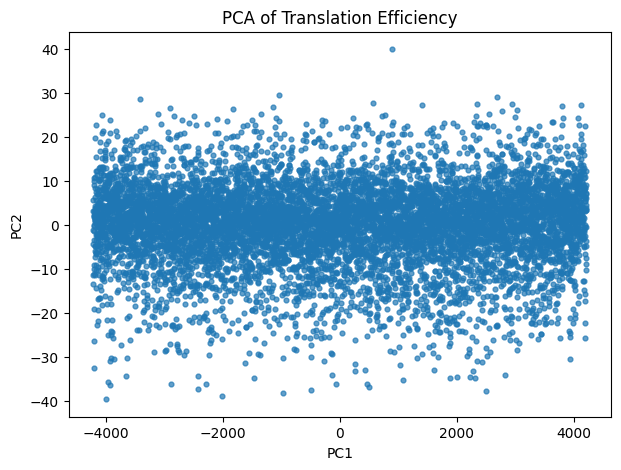

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

rna, te = load_data()

pca = PCA(n_components=2)
te_pca = pca.fit_transform(te.values)

plt.figure(figsize=(7,5))
plt.scatter(te_pca[:,0], te_pca[:,1], s=12, alpha=0.7)
plt.title("PCA of Translation Efficiency")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


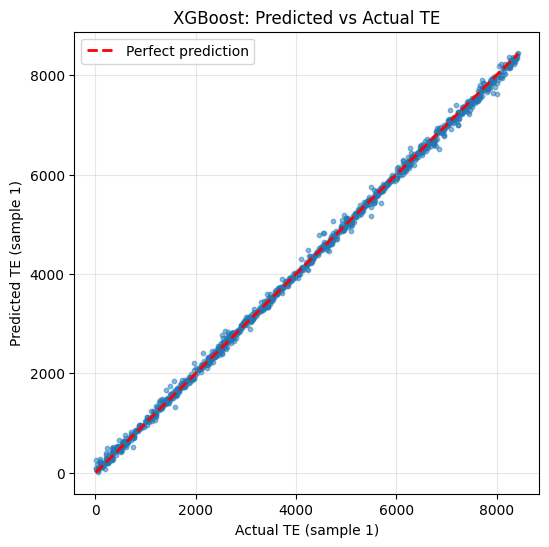

In [10]:
import matplotlib.pyplot as plt

rna, te = load_data()
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(rna.values, te.values)

xgb = get_xgboost()
xgb.fit(X_train, y_train)

pred = xgb.predict(X_val)

plt.figure(figsize=(6,6))
plt.scatter(y_val[:,0], pred[:,0], alpha=0.5, s=10)
plt.plot([y_val[:,0].min(), y_val[:,0].max()], 
         [y_val[:,0].min(), y_val[:,0].max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel("Actual TE (sample 1)")
plt.ylabel("Predicted TE (sample 1)")
plt.title("XGBoost: Predicted vs Actual TE")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
